In [1]:
import h5py
from scipy import ndimage
####### baryonification experiment code from Ben Horowitz

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/global/homes/j/jialiu/.conda/envs/hacking_env/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [5]:
folder = "/global/cscratch1/sd/jialiu/BABAMAS"
f = h5py.File(folder+"/Mnu_0_WMAP9_cone_0_kappa_zs_1p0.hdf5", 'r')
g = h5py.File(folder+"/Mnu_0_DMONLY_WMAP9_cone_0_kappa_zs_1p0.hdf5", 'r')

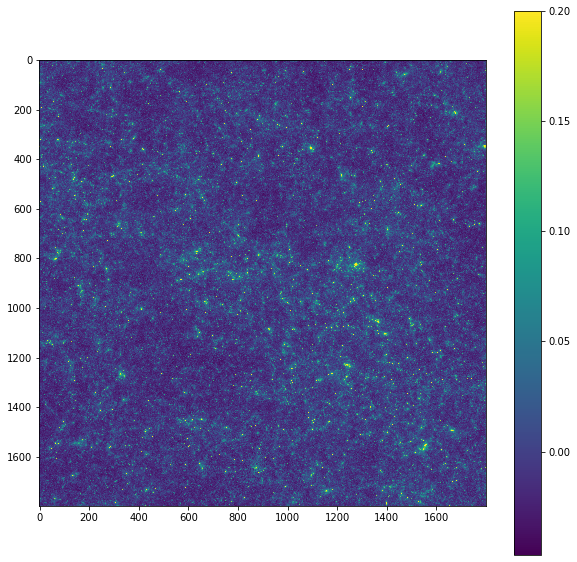

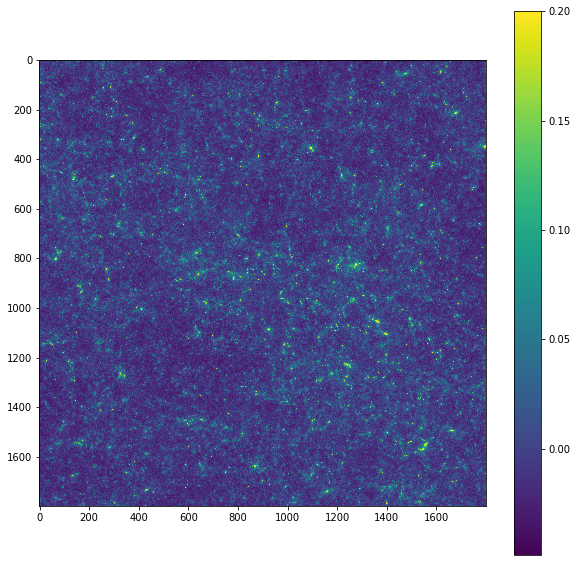

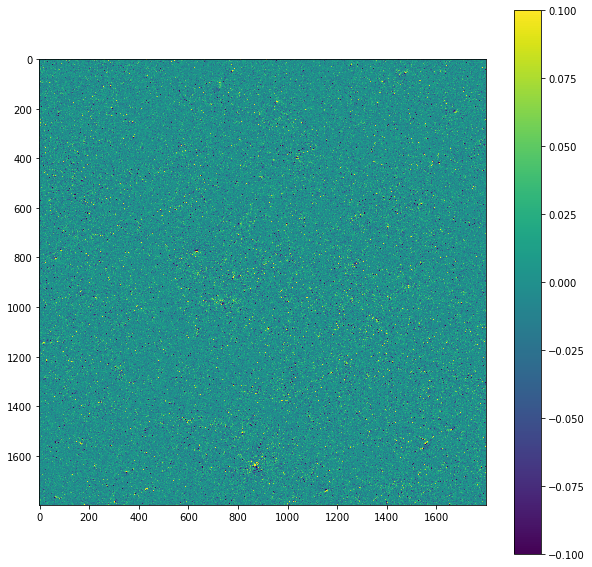

In [6]:
plt.figure(figsize=(10,10))

imshow(f["kappa_zs_1_ran0"],vmax=0.2)
colorbar()
plt.show()

plt.figure(figsize=(10,10))

imshow(g["kappa_zs_1_ran0"],vmax=0.2)
colorbar()
plt.show()


plt.figure(figsize=(10,10))

imshow(np.array(g["kappa_zs_1_ran0"])-np.array(f["kappa_zs_1_ran0"]),vmin=-0.1,vmax=0.1)
colorbar()
plt.show()

[]

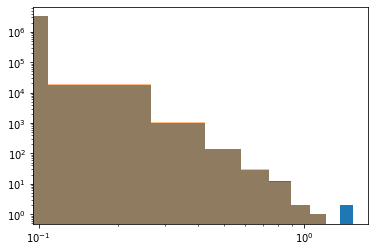

In [7]:
_,bins, _ = plt.hist(np.array(g["kappa_zs_1_ran0"]).flatten())
plt.hist(np.array(f["kappa_zs_1_ran0"]).flatten(),bins=bins,alpha = 0.5)

plt.loglog()

In [8]:
g["kappa_zs_1_ran0"].shape

(1800, 1800)

In [9]:
#importing packages, many probably won't be useful

import keras
import tensorflow as tf
from keras.layers import Conv2D,Flatten,Conv2DTranspose,concatenate
from keras.layers import Input, Dense, Lambda, concatenate,Reshape,Flatten
from keras.layers import Reshape,UpSampling2D,RepeatVector,Conv2D,MaxPool2D, AvgPool2D
from keras.layers import Dropout, BatchNormalization
from keras import optimizers

from keras.models import Model
from keras import backend as K

#channels are essentially data-fields (in case you want to map from multiple fields to one/multiple output fields)
#in this case it goes (# of data entries, channels, x, y), as opposed to (# of data entries, x, y, channels)
keras.backend.set_image_data_format('channels_first')


Using TensorFlow backend.


In [10]:
#layers definitions, very minimal, one "skip" connection


l1 = Conv2D(5,3,padding="same",activation="selu")#can play around alot with activations!
l2 = Conv2D(8,3,padding="same",activation="selu")
l3 = Conv2D(16,3,padding="same",activation="tanh")
l4 = Conv2D(8,3,padding="same",activation="selu")
l5 = Conv2D(2,3,padding="same",activation="selu")
l6 = Conv2D(1,2,padding="same",activation="tanh")


#setting up the "flow" of the network
x_in = Input(shape=(5,1800, 1800),name="field")

x = l1(x_in)
x = l2(x)
x = l3(x)
x = l4(x)

x = concatenate([x,x_in],axis=1) #skip connection

x = l5(x)
x = l6(x)

#defining start point and end point of model
simple = Model(x_in, x)

#checking output shape is correct
print(x.shape)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
(?, 1, 1800, 1800)


In [11]:
simple.summary() #very "small" model by neural network standards

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
field (InputLayer)              (None, 5, 1800, 1800 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 5, 1800, 1800 230         field[0][0]                      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 8, 1800, 1800 368         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 16, 1800, 180 1168        conv2d_2[0][0]                   
____________________________________________________________________________________________

In [21]:
#optimizer choice, Adam is the current fan favorite. Currently using the default parameters for it.
#Adam uses "momentum information" to smooth out optimization...
adam = optimizers.adam(lr=0.001)



In [22]:
from keras import objectives
#defining objective function and optimizer to use
simple.compile(optimizer=adam,loss=objectives.mean_squared_error)


In [33]:
def batch_gen (i):
    '''i goes from 0 to 24'''
    #quicky fitting
    xfield = np.array(g["kappa_zs_1_ran%s"%(i)]).reshape(1,1,1800,1800)
    yfield = np.array(f["kappa_zs_1_ran%s"%(i)]).reshape(1,1,1800,1800)
    ### to add more maps: reshape(1,1,1800,1800) into (10,1,1800,1800)

    #extracting some features... currently just the smoothed map at a variety of scales...
    xfield2 = ndimage.gaussian_filter(xfield,5)
    xfield3 = ndimage.gaussian_filter(xfield,10)
    xfield4 = ndimage.gaussian_filter(xfield,25)
    xfield5 = ndimage.gaussian_filter(xfield,50)

    xfield_n = np.hstack([xfield,xfield2,xfield3,xfield4,xfield5])
    return xfield, xfield_n, yfield

#     print(xfield_n.shape) #note there are now five channels!

In [34]:
xfield_test, xfield_n_test, yfield_test = batch_gen (24)
xfield_train, xfield_n_train, yfield_train = batch_gen (0)

In [24]:
# #quicky fitting
# xfield = np.array(g["kappa_zs_1_ran0"]).reshape(1,1,1800,1800)
# yfield = np.array(f["kappa_zs_1_ran0"]).reshape(1,1,1800,1800)
# ### to add more maps: reshape(1,1,1800,1800) into (10,1,1800,1800)

# #extracting some features... currently just the smoothed map at a variety of scales...
# xfield2 = ndimage.gaussian_filter(xfield,5)
# xfield3 = ndimage.gaussian_filter(xfield,10)
# xfield4 = ndimage.gaussian_filter(xfield,25)
# xfield5 = ndimage.gaussian_filter(xfield,50)

# xfield_n = np.hstack([xfield,xfield2,xfield3,xfield4,xfield5])

# print(xfield_n.shape) #note there are now five channels!

In [30]:
simple.fit(x=xfield_n_train,y=yfield_train,batch_size=1,epochs=1000)

Epoch 1/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 2/1000
1/1 [==============================] - 3s 3s/step - loss: 8.5933e-04
Epoch 3/1000
1/1 [==============================] - 3s 3s/step - loss: 7.2382e-04
Epoch 4/1000
1/1 [==============================] - 3s 3s/step - loss: 6.3955e-04
Epoch 5/1000
1/1 [==============================] - 3s 3s/step - loss: 5.8222e-04
Epoch 6/1000
1/1 [==============================] - 3s 3s/step - loss: 5.3735e-04
Epoch 7/1000
1/1 [==============================] - 3s 3s/step - loss: 4.9967e-04
Epoch 8/1000
1/1 [==============================] - 3s 3s/step - loss: 4.6571e-04
Epoch 9/1000
1/1 [==============================] - 3s 3s/step - loss: 4.3423e-04
Epoch 10/1000
1/1 [==============================] - 3s 3s/step - loss: 4.0544e-04
Epoch 11/1000
1/1 [==============================] - 3s 3s/step - loss: 3.8035e-04
Epoch 12/1000
1/1 [==============================] - 3s 3s/step - loss: 3.5934e-04
Epoch 13/1000
1/1

KeyboardInterrupt: 

In [32]:
output_test = simple.predict(xfield_n_test)
output_train = simple.predict(xfield_n_train)

In [40]:
output_train

array([[[[-0.00323312, -0.00887284, -0.0175041 , ..., -0.02008172,
          -0.01088811, -0.01544102],
         [-0.00497126, -0.00921468, -0.00534533, ..., -0.00319045,
          -0.00140167, -0.00551384],
         [-0.00612138, -0.01153279, -0.01133851, ..., -0.01247989,
          -0.00246671, -0.00190069],
         ...,
         [-0.01059343, -0.03862884, -0.02968173, ..., -0.01352564,
          -0.02074169, -0.00853521],
         [-0.0092692 , -0.02500732, -0.02024462, ..., -0.00872436,
          -0.02820075, -0.01008744],
         [-0.02196156, -0.02567528, -0.01765837, ..., -0.01592094,
          -0.03058864, -0.01303309]]]], dtype=float32)

In [41]:
########## L2 error
def calc_L2 (xfield, yfield, output):
    return np.sum((output[0,0]-yfield[0,0])**2.0)/np.sum((xfield[0,0]-yfield[0,0])**2.0)
######## was 0.7
L2_train = calc_L2 (xfield_train, yfield_train, output_train)
L2_test = calc_L2 (xfield_test, yfield_test, output_test)
print (L2_train, L2_test)

0.7590762 0.7600553


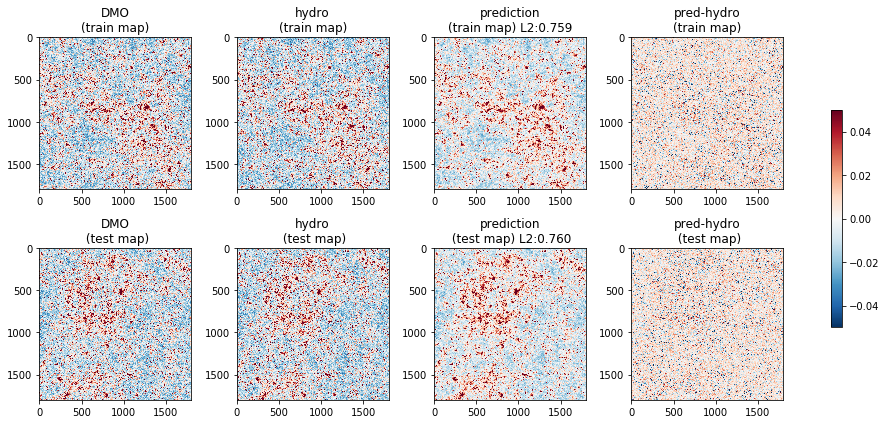

In [81]:
main_titles = ['(train map)',' (test map)']
sub_titles = ['DMO', 'hydro', 'prediction', 'pred-hydro']
fields_all = [[xfield_train, yfield_train, output_train, output_train-yfield_train],
              [xfield_test, yfield_test, output_test, output_test-yfield_test]]

f, axes = subplots(2,4, figsize=(14,6))

for i in range(2):
    for j in range(4):
        ititle=sub_titles[j]+'\n'+main_titles[i]
        if j==2:
            ititle+=' L2:%.3f'%([L2_train,L2_test][i])
        axes[i][j].set_title(ititle)
        pcm=axes[i][j].imshow(fields_all[i][j][0,0],vmin=-0.05,vmax=0.05,cmap='RdBu_r')
plt.tight_layout()
f.colorbar(pcm, ax=[axes[:, :]], location='right', shrink=0.6)
